In [3]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image


from tqdm import tqdm
import os
import random

from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sayantghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sayantghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
import keras
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [6]:
df = pd.read_csv('Data/spam.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df = df[['label', 'message']]
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Feature Engineering

In [7]:
df['message_length'] = df['message'].apply(lambda x: len(x.split()))
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [8]:
balance_counts = df.groupby('label')['label'].agg('count')
balance_counts

label
ham     4825
spam     747
Name: label, dtype: int64

## EDA (Exploratory Data Analysis)

In [9]:
fig = go.Figure(
    data=[
        go.Bar(
            x=balance_counts.index,
            y=balance_counts.values,
            text=balance_counts.values,
            textposition='auto',
        )
    ]
)
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()


In [10]:
ham_df = df[df['label'] == 'ham']['message_length'].value_counts().sort_index()
spam_df = df[df['label'] == 'spam']['message_length'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy'
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy'
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()


# 3 Data Preprocessing

## 3.1 Cleaning The Corpus

In [11]:
def clean_text(text):
    '''
    Clean the input text by performing the following steps:
    1. Convert text to lowercase.
    2. Remove text inside square brackets.
    3. Remove URLs (http, https, www).
    4. Remove HTML tags.
    5. Remove punctuation.
    6. Remove newline characters.
    7. Remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,label,message,message_length,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


## 3.2 Removing Stop Words

In [13]:
## Stopwords Removal
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()


,label,message,message_length,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


## 3.3 Stemming and Lemmatization

`Stemming/ Lematization`
For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word.

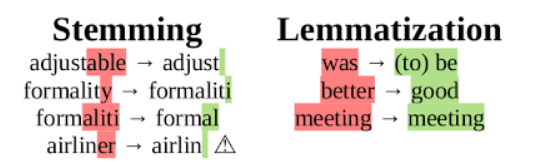

In [14]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,label,message,message_length,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## 3.4 Label Encoding 

Label encoding is a technique used to convert categorical variables into numerical values. This is particularly useful for machine learning algorithms that require numerical input. Each unique category in the variable is assigned a unique integer value.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])

df['label_encoded'] = le.transform(df['label'])
df.head()

,label,message,message_length,message_clean,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


## 5 Vectorization : CountVectorizer, TF-IDF

In [16]:
x = df['message_clean']
y = df['label_encoded']

print(len(x), len(y))

5572 5572


In [17]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [19]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

----

## 5.1 Tokenization
Tokenization is the process of converting a sequence of characters into a sequence of tokens, which can be words, phrases, or symbols. It is a crucial step in natural language processing (NLP) as it allows the model to understand and process text data.

In [20]:
texts = df['message_clean']
target = df['label_encoded']

In [21]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6769

In [22]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3199,  276, ...,    0,    0,    0],
       [   8,  239,  532, ...,    0,    0,    0],
       [   9,  361,  591, ...,    0,    0,    0],
       ...,
       [6767, 1007, 6768, ...,    0,    0,    0],
       [ 139, 1257, 1612, ...,    0,    0,    0],
       [1998,  382,  171, ...,    0,    0,    0]])

In [23]:
length_long_sentence, len(train_padded_sentences[0])

(80, 80)

## 5.2 Embeddding
Word embeddings are a type of word representation that allows words to be represented as vectors in a continuous vector space. This representation captures the semantic meaning of words, allowing similar words to have similar vector representations. GloVe (Global Vectors for Word Representation) is one of the popular methods for generating word embeddings.

In [24]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('Glove-Embeddings/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [25]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 6: Model Training

In [26]:
import plotly.figure_factory as ff
x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    z = np.flip(z, 0)
    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(
        z, x=x, y=y, annotation_text=z_text, colorscale='Blues', showscale=True,
        font_colors=['black'], hoverinfo='z'
    )

    fig.update_layout(
        title='<b>Confusion Matrix</b>',
        xaxis=dict(title='Predicted Label', showgrid=False, zeroline=False, tickfont=dict(size=14)),
        yaxis=dict(title='Actual Label', showgrid=False, zeroline=False, tickfont=dict(size=14)),
        font=dict(family="Arial", size=16),
        plot_bgcolor='white',
        margin=dict(l=80, r=80, t=80, b=80)
    )
    fig.update_traces(showscale=True)
    return fig


## Naive Bayes

In [27]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [28]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

# calculate accuracy of class predictions
from sklearn import metrics
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_class):.3f}")

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Accuracy: 0.978


In [29]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

## Logistic Regression

In [30]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(x_train_dtm, y_train)

ytest = np.array(y_test)
pred_y = model_lr.predict(x_test_dtm)

print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9461593682699211
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1202
           1       0.96      0.63      0.76       191

    accuracy                           0.95      1393
   macro avg       0.95      0.81      0.87      1393
weighted avg       0.95      0.95      0.94      1393



In [36]:
#x_test_dtm